# Aufgabe 3 - Aktuelle Data Science Entwicklungen

Name: Marco Zeulner

Matrikelnummer: 1633641

## Relevant Imports

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle_environments

from tqdm.notebook import trange
from tqdm import trange
from typing import Tuple, List, Dict, Any

Loading environment lux_ai_s2 failed: No module named 'vec_noise'


In [2]:
#Set seed for reproduceability
torch.manual_seed(42)

## Definition of the game "VierGewinnt"

In [3]:
class ConnectFour:
    """
    Class that implements a Connect Four game model.
    """

    def __init__(self):
        """
        Initialize game model.
        """
        # Define the number of rows and columns in the game board
        self.row_count = 6
        self.column_count = 7
        # The number of possible actions is equal to the number of columns (each column is a potential spot for the next token)
        self.action_size = self.column_count
        # Define how many consecutive tokens are needed for a win (standard Connect Four rules require four in a row)
        self.in_a_row = 4

    def __repr__(self) -> str:
        """
        Return class representation.
        
        Returns:
            str: Class representation.
        """
        return "ConnectFour"

    def get_initial_state(self) -> np.ndarray:
        """
        Get the initial game state.

        Returns:
            np.ndarray: Zero-initialized game state. 
        """
        # The game starts with an empty board, so return a zero-filled array of the board's shape
        return np.zeros((self.row_count, self.column_count))

    def get_next_state(self, state: np.ndarray, action: int, player: int) -> np.ndarray:
        """
        Get the game state after a player action.

        Args:
            state (np.ndarray): Current game state.
            action (int): Player action (column where the player wants to put his token).
            player (int): Current player (1 or -1).

        Returns:
            np.ndarray: Updated game state.
        """
        # Find the highest empty row in the selected column
        row = np.max(np.where(state[:, action] == 0))
        # Place the player's token in the highest empty row of the selected column
        state[row, action] = player
        return state

    def get_valid_moves(self, state: np.ndarray) -> np.ndarray:
        """
        Get valid moves for the current state.

        Args:
            state (np.ndarray): Current game state.

        Returns:
            np.ndarray: Boolean mask of valid moves.
        """
        # In Connect Four, a move is valid if the top row of the selected column is empty. 
        # Return a boolean mask where each entry corresponds to a column and the value is 1 if the top cell is empty and 0 otherwise.
        return (state[0] == 0).astype(np.uint8)

    def _count_in_direction(self, state: np.ndarray, action: int, offset_row: int, offset_column: int, player: int) -> int:
        """
        Helper function to count consecutive tokens in a specific direction.

        Args:
            state (np.ndarray): Current game state.
            action (int): Last move made (the column of the last token placed).
            offset_row (int): Row direction offset (-1, 0, or 1) to specify the direction to check.
            offset_column (int): Column direction offset (-1, 0, or 1) to specify the direction to check.
            player (int): Current player (1 or -1).

        Returns:
            int: Number of consecutive tokens in the specified direction.
        """
        # Find the row of the last token placed
        row = np.min(np.where(state[:, action] != 0))
        
        # Starting from the position of the last token, count how many consecutive tokens belong to the player in the specified direction.
        # Stop if we reach the edge of the board or if a token belongs to the other player.
        for i in range(1, self.in_a_row):
            r = row + offset_row * i
            c = action + offset_column * i
            if (
                r < 0 
                or r >= self.row_count
                or c < 0 
                or c >= self.column_count
                or state[r][c] != player
            ):
                return i - 1
        return self.in_a_row - 1

    def check_win(self, state: np.ndarray, action: int) -> bool:
        """
        Check if the game is won.

        Args:
            state (np.ndarray): Current game state.
            action (int): Last move made.

        Returns:
            bool: True if game is won, False otherwise.
        """
        # If no action was made, the game is not won
        if action is None:
            return False
        
        # Find the row of the last token placed
        row = np.min(np.where(state[:, action] != 0))
        # Identify the player who made the last move
        player = state[row][action]

        # Check for a win in each direction: vertical, horizontal, and both diagonals
        # A win is defined as having four of the player's tokens in a row in any direction
        return (
            self._count_in_direction(state, action, 1, 0, player) >= self.in_a_row - 1 # vertical
            or (self._count_in_direction(state, action, 0, 1, player) + self._count_in_direction(state, action, 0, -1, player)) >= self.in_a_row - 1 # horizontal
            or (self._count_in_direction(state, action, 1, 1, player) + self._count_in_direction(state, action, -1, -1, player)) >= self.in_a_row - 1 # top left diagonal
            or (self._count_in_direction(state, action, 1, -1, player) + self._count_in_direction(state, action, -1, 1, player)) >= self.in_a_row - 1 # top right diagonal
        )

    def get_value_and_terminated(self, state: np.ndarray, action: int) -> Tuple[int, bool]:
        """
        Get game value and termination status.

        Args:
            state (np.ndarray): Current game state.
            action (int): Last move made.

        Returns:
            Tuple[int, bool]: Game value and termination status.
        """
        # If the game has been won by the player who made the last move, the game is terminated and the value is 1
        if self.check_win(state, action):
            return 1, True
        # If no valid moves are left, the game is a draw (value 0) and is terminated
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        # Otherwise, the game is not terminated and has no value yet
        return 0, False

    def get_opponent(self, player: int) -> int:
        """
        Get the opponent of the current player.

        Args:
            player (int): Current player.

        Returns:
            int: The opponent.
        """
        # In this game, players are represented by 1 and -1, so the opponent is just the negative of the player
        return -player

    def get_opponent_value(self, value: int) -> int:
        """
        Get the value for the opponent.

        Args:
            value (int): Current player value.

        Returns:
            int: The opponent's value.
        """
        # The value for the opponent is the negative ofthe current player's value
        return -value

    def change_perspective(self, state: np.ndarray, player: int) -> np.ndarray:
        """
        Change the perspective of the game state based on the player.

        Args:
            state (np.ndarray): Current game state.
            player (int): Current player.

        Returns:
            np.ndarray: Updated game state.
        """
        # Multiply the state by the player's number to switch perspective between players
        return state * player

    def get_encoded_state(self, state: np.ndarray) -> np.ndarray:
        """
        Get the encoded game state.

        Args:
            state (np.ndarray): Current game state.

        Returns:
            np.ndarray: Encoded game state.
        """
        # Encode the game state as three binary matrices representing player -1's tokens, empty cells, and player 1's tokens, respectively
        encoded_state = np.stack((state == -1, state == 0, state == 1)).astype(np.float32)

        # Swap axes if the state is 3-dimensional, in order to have the proper shape for machine learning models
        if len(state.shape) == 3:
            encoded_state = np.swapaxes(encoded_state, 0, 1)

        return encoded_state


## Definition of the neural network, which is trained to predict the policy and the state value

The architecture used in this example is the same that was used for AlphaZero. The decision for a Residual Network was made because of the capability to be trainable even when using many layer.

The neural networks gets as input the current state and outputs the policy vector and state-value scalar:
$$ (p,v)=f_{\theta}(s) $$

with:
- $ p_a = P(a|s) $
- $ v \approx \mathbb{E}[z|s] $

The neural network was trained with the following loss function (again same as in the original paper):
$$ l = (z-v)^2 - \pi^Tlog(p) + c||\theta||^2 $$

with
- $ (z-v)^2 $ being the mean-squared error for the state-value scalar
- $ - \pi^Tlog(p) $ being the cross-entropy loss for the policy vector
- $ c||\theta||^2 $ being L2 regularisation to avoid overfitting

The architecture of the neural network looks as follow:

![neural_network](images/neural_network.png)


In [4]:
class ResNet(nn.Module):
    """
    Class representing the Residual Network model.
    """

    def __init__(self, game: ConnectFour, num_res_blocks: int, num_hidden: int, device: str):
        """
        Initialize the Residual Network.

        Args:
            game (object): The game object. This object is used to determine
                           the dimension of the final layer in the policy and value heads.
            num_res_blocks (int): The number of residual blocks. Residual blocks are part of the 
                                  architecture of the ResNet model and help it to learn deeper representations.
            num_hidden (int): The number of hidden layers. This is used in the residual blocks and 
                              the initial convolutional layer.
            device (str): The device to be used (i.e., 'cpu' or 'cuda'). This is used to move 
                          the model to the appropriate device for computation.
        """
        super().__init__()

        self.device = device

        # The starting block of the model. It consists of a convolutional layer, batch normalization,
        # and a rectified linear unit (ReLU) activation function.
        self.start_block = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )

        # The main backbone of the model. It consists of a number of residual blocks. 
        # These blocks allow for deeper networks by providing paths for the gradients to flow during backpropagation.
        self.backbone = nn.ModuleList(
            [ResBlock(num_hidden) for _ in range(num_res_blocks)]
        )

        # The policy head of the model. It is used to determine the best action to take (policy vector). It consists of a 
        # convolutional layer, batch normalization, a ReLU activation, flattening of the data, and a linear layer.
        self.policy_head = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )

        # The value head of the model. It is used to evaluate the state-value scalar of the current state. It consists of a 
        # convolutional layer, batch normalization, a ReLU activation, flattening of the data, a linear layer, and a tanh activation.
        self.value_head = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )

        # Move the entire model to the designated device for computation.
        self.to(device)

    def forward(self, x) -> Tuple[nn.Module, nn.Module]:
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            Tuple[nn.Module, nn.Module]: Policy and value.
        """
        # The input x is passed through the starting block.
        x = self.start_block(x)

        # Then, x is passed through each of the residual blocks in the backbone.
        for res_block in self.backbone:
            x = res_block(x)

        # The output from the backbone is then passed through the policy head and the value head.
        policy = self.policy_head(x)
        value = self.value_head(x)

        # The function returns the policy (a probability distribution over the actions) and 
        # the value (a scalar evaluation of the input state) as a tuple.
        return policy, value

class ResBlock(nn.Module):
    """
    Class representing a Residual Block.
    """

    def __init__(self, num_hidden: int):
        """
        Initialize the Residual Block.

        Args:
            num_hidden (int): The number of hidden layers. This determines the number of channels 
                              in the convolutional layers.
        """
        super().__init__()

        # A residual block consists of two convolutional layers, each followed by a batch normalization layer.
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x) -> nn.Module:
        """
        Forward pass through the block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            nn.Module: Output after block operations.
        """
        # The original input x is saved as a residual. This will be added back to the output 
        # of the block, creating a 'shortcut' connection that helps the gradient to backpropagate in deeper networks.
        residual = x

        # The input is passed through the first convolutional layer, followed by a batch normalization and a ReLU activation.
        x = F.relu(self.bn1(self.conv1(x)))

        # The output of the first set of layers is then passed through the second convolutional layer, 
        # followed by a batch normalization. The previously saved residual is then added to this output.
        x = self.bn2(self.conv2(x))
        x += residual

        # The result is then passed through a final ReLU activation before being returned as the output of the block.
        x = F.relu(x)

        return x

## Definition of a single node in the search tree used by Monte Carlo Tree Search

Monte Carlo Tree Search is using a tree structure, where each node represents a game state and each edge an action. The root node represents the current game state and from there on possible future states/nodes are generated.

The following picture shows an example tree for the game of chess. The root state represents the current state and white is to make a move. All childs of the s0 indicate the possible moves white can make:
![tree_chess](images/Tree_Chess.png)


Each node comprises three properties:
1. Visit-Count: This number represents how often this state was traversed during MCTS
2. Prior Probability: This number represents the probability assigned to this specific action which we receive from the neural network (policy vector)
3. State-Value: This number represents how this state is rated

In [5]:
class Node:
    """
    Class representing a Node for the MCTS (Monte Carlo Tree Search).
    """

    def __init__(self, game: ConnectFour, args: dict, state, parent=None, action_taken=None, prior=0, visit_count=0):
        """
        Initialize the node.

        Args:
            game (object): An instance of the ConnectFour game. This object is used 
                           to generate child states and evaluate game outcomes.
            args (dict): Arguments for the Node.
            state (np.array): The state of the ConnectFour game at this node, represented as a numpy array.
            parent (Node, optional): Parent of this node. None for root node. Defaults to None.
            action_taken (any, optional): The action taken in the parent node to reach this node. Defaults to None.
            prior (int, optional): Prior probability of this node, given by the neural network. Defaults to 0.
            visit_count (int, optional): Number of visits to this node during MCTS. Defaults to 0.
        """
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        self.children = []
        self.visit_count = visit_count
        self.value_sum = 0  # Sum of values from each simulation run through this node.

    def is_fully_expanded(self) -> bool:
        """
        Check if the node is fully expanded.

        Returns:
            bool: True if the node has children (i.e., is fully expanded), False otherwise.
        """
        return len(self.children) > 0

    def select(self):
        """
        Select the best child of this node, based on the Upper Confidence Bound (UCB) value.

        Returns:
            Node: The best child node.
        """
        best_child = None
        best_ucb = -np.inf

        # Iterate through each child and calculate its UCB.
        # Select the child with the highest UCB.
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child) -> float:
        """
        Calculate the Upper Confidence Bound (UCB) for a child node.
        UCB is used in MCTS to balance exploration and exploitation.

        Args:
            child (Node): The child node.

        Returns:
            float: The UCB of the child node.
        """
        if child.visit_count == 0:
            q_value = 0  # Q-value is the expected reward of the action at the node.
        else:
            # Calculate Q-value as the average result of actions taken from this node.
            # This is adjusted to be in the range [0, 1].
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2

        # UCB calculation involves both the Q-value (mean reward) and a term that encourages exploration.
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

    def expand(self, policy) -> 'Node':
        """
        Expand this node by creating new children. This is typically done by applying 
        all possible actions to this node's state.

        Args:
            policy (list): The policy to be used for expansion, given as a probability 
                           distribution over actions.

        Returns:
            Node: The last expanded child node.
        """
        for action, prob in enumerate(policy):
            if prob > 0:  # Only consider actions with non-zero probability.
                child_state = self.state.copy()
                
                # Get the new state after taking the action.
                child_state = self.game.get_next_state(child_state, action, 1)
                
                # Change the perspective so that the next player is always "player 1".
                child_state = self.game.change_perspective(child_state, player=-1)

                # Create a new child node for this action.
                child = Node(self.game, self.args, child_state, self, action, prob)
                
                # Add the new child to the list of children.
                self.children.append(child)

        return child

    def backpropagate(self, value: float):
        """
        Backpropagate the value to the parent of the node. This function is called 
        when the simulation reaches a terminal state, and the outcome (value) needs 
        to be backpropagated up the tree.

        Args:
            value (float): The value to be backpropagated.
        """
        # Increment the total value and visit count of the node.
        self.value_sum += value
        self.visit_count += 1

        # Invert the value for the opponent.
        value = self.game.get_opponent_value(value)
        
        # If the node has a parent, apply the same backpropagation to it.
        if self.parent is not None:
            self.parent.backpropagate(value)


## Definition of the Monte Carlo Tree Search algorithm

This algorithm is ultimately used to determine the next move. However, as a side-product, it plays against itself in a self-play manner and thereby produces trainings data which we can afterwards use for the neural network.
As an alternative, "Bruteforce" could be used, where all possible candidate moves are evaluated to a certain depth. This is extremely resource intensive and impossible for games like chess because of the high branching factor (Sometimes like 30 possible moves for each position). Therefore we must focus on promising paths and there comes MCTS into play.

This algorithm consists of three phases:

1. **Select**: 
        
    This is the process of traversing the tree from the root node until a leaf node. This process involves making a choice at each decision point, balancing exploration (choosing actions which haven't been tried much in the past) and exploitation (choosing actions which have high average reward). AlphaZero uses a formula called the Upper Confidence Bound applied to Trees (UCT) to make this decision:
        $$a_t=\arg\max_{a} \left( \frac{W_a}{N_a} + c \cdot p_a \cdot \sqrt{\frac{ln(N_p)}{1+N_a}} \right)$$

    With:

    - $a_t$ is the action to take at state s.

    - $W_a$ is the reward assigned to a certain action.

    - $N_a$ is the Visit-Count assigned to a certain action.

    - $c$ is a hyperparameter deciding whether to foster exploration or exploitation (low c -> exploitation; high c -> exploration)

    - $p_a$ is the prior probability of selecting action a at state s, given by the policy network.

    - $N_p$ is the Visit-Count of the parent node

2. **Expand**: 
    - Once we reach a leaf node (not yet explored), we add for each possible action a child to the node. The policy network provides prior probabilities $p_a$ for the new nodes.

3. **Backup**: 
    - After the expansion, the state-values are updated along the tree path from the new node to the root. This involves propagating the values from the value network backwards, and updating the $W_a$'s
  

After several iterations (hyperparameter) the next move is determined by taking the one with the highest visit count.
The following new policy $\pi$ serves as target policy to train for:
$$\pi = \frac{N(a)}{\sum_{b \in A} N(b)}$$

After the game the new target value z is also available which servers as target value for the state-value scalar.


In [6]:
class MCTS:
    """
    Class representing the Monte Carlo Tree Search (MCTS) algorithm
    """

    def __init__(self, game: ConnectFour, args: dict, model: ResNet):
        """
        Initialize the MCTS.

        Args:
            game (object): The ConnectFour game object, which encodes the game rules and mechanics.
            args (dict): Arguments for the MCTS, like the number of searches to conduct and 
                         parameters for adding Dirichlet noise to the policies.
            model (ResNet): The neural network model, which gives a policy (i.e., probability 
                            distribution over possible actions) and a value (i.e., estimated 
                            reward) for a given state.
        """
        self.game = game
        self.args = args
        self.model = model

    def _calculate_policy(self, state: np.array) -> np.array:
        """
        Calculate the policy for the given state. This function adds some exploration noise 
        to the policy and masks out invalid actions.

        Args:
            state (np.array): The state to calculate the policy for, represented as a numpy array.

        Returns:
            np.array: The calculated policy, represented as a numpy array.
        """
        # Use the neural network to calculate the raw policy and value for this state.
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state), device=self.model.device).unsqueeze(0)
        )

        # Apply a softmax function to the raw policy to turn it into a probability distribution.
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()

        # Add Dirichlet noise to the policy for exploration. The dirichlet_alpha parameter 
        # controls the amount of randomness in the noise, and the dirichlet_epsilon parameter 
        # controls the weight of the noise in the final policy.
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size)

        # Get the valid moves in the current state and use them to mask the policy. This 
        # ensures that we do not consider invalid actions.
        valid_moves = self.game.get_valid_moves(state)
        policy *= valid_moves

        # Normalize the policy so that its elements sum to 1.
        policy /= np.sum(policy)

        return policy

    def _expand_node(self, node: 'Node', policy: np.array):
        """
        Expand the given node based on the policy. In MCTS, a node is expanded by adding 
        child nodes for each possible action.

        Args:
            node (Node): The node to expand.
            policy (np.array): The policy to use for expanding. The policy is a probability 
                               distribution over actions.
        """
        # The value of a node is the reward from the perspective of the player who is about 
        # to play. However, the MCTS algorithm operates from the perspective of the current 
        # player. Thus, we need to convert the value to the opponent's perspective before 
        # using it in the MCTS.
        value = node.game.get_opponent_value(node.value_sum)

        # Use the policy to expand the node.
        node.expand(policy)

        # Backpropagate the value up the tree.
        node.backpropagate(value)

    @torch.no_grad()  # We do not need gradients during the search.
    def search(self, state: np.array) -> np.array:
        """
        Conduct a search on the state using MCTS. The search involves running multiple simulations 
        starting from the given state, and updating the Q-values and visit counts of the nodes 
        encountered in the simulations. The output is a probability distribution over actions.

        Args:
            state (np.array): The state to conduct a search on, represented as a numpy array.

        Returns:
            np.array: The probabilities of taking each action from the state, after the MCTS.
        """
        # Create a root node for the state.
        root = Node(self.game, self.args, state, visit_count=1)

        # Calculate the policy for the root node using the neural network.
        policy = self._calculate_policy(state)

        # Expand the root node based on this policy.
        root.expand(policy)

        # Loop over the number of searches to conduct.
        for _ in range(self.args['num_searches']):
            node = root

            # Keep selecting the best child node until we reach a node that is not fully expanded.
            while node.is_fully_expanded():
                node = node.select()

            # Get the value and termination status of the game from the perspective of the 
            # player who just played. The value is the estimated reward for the player, and 
            # the termination status indicates whether the game has ended.
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)

            # If the game has not ended, then we can expand the node and backpropagate the value.
            if not is_terminal:
                # Calculate a new policy for this node.
                policy = self._calculate_policy(node.state)

                # Expand the node based on this policy and backpropagate the value.
                self._expand_node(node, policy)

            # Regardless of whether the game has ended, we need to backpropagate the value 
            # up the tree to update the Q-values and visit counts of the ancestor nodes.
            node.backpropagate(value)    

        # After all the searches, we use the visit counts of the children of the root to 
        # calculate the action probabilities. The idea is that the actions that led to 
        # more promising outcomes should have been visited more.
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count

        # Normalize the action probabilities so that they sum to 1.
        action_probs /= np.sum(action_probs)
        
        return action_probs


## Definition of the overall AlphaZero algorithm which encompasses the neural network and MCTS

In [7]:
class AlphaZero:
    """
    The main AlphaZero agent. This class orchestrates the training process for the AlphaZero algorithm.
    It includes methods for executing games using self-play, collecting training data, and training
    the neural network model.
    """

    def __init__(self, model: ResNet, optimizer: torch.optim.Optimizer, game: ConnectFour, args: dict):
        """
        Args:
            model (ResNet): The ResNet model that is used for learning and predicting.
            optimizer (torch.optim.Optimizer): The optimizer used to update the model.
            game (ConnectFour): The game instance of ConnectFour.
            args (dict): Hyperparameters for the learning process.
        """
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        # Monte Carlo Tree Search is initialized with the game, arguments, and the model
        self.mcts = MCTS(game, args, model)
        self.losses = []

    def self_play(self) -> List[Tuple[np.ndarray, np.ndarray, float]]:
        """
        AlphaZero plays a game against itself and stores the gameplay data.
        
        Returns:
            List[Tuple[np.ndarray, np.ndarray, float]]: Game data, including the state, probabilities of actions, and the reward.
        """
        # Initialize memory to hold gameplay data, initial player, and the initial state
        memory, player, state = self.initialize_self_play()
        # Use memory, initial player, and state to play a game to the end
        return self.play_game(memory, player, state)

    def train(self, memory: List[Tuple[np.ndarray, np.ndarray, float]]):
        """
        Trains the ResNet model on the collected gameplay data.

        Args:
            memory (List[Tuple[np.ndarray, np.ndarray, float]]): The gameplay data collected from self-play.
        """
        # Shuffle the gameplay data to prevent the model from learning the order of play
        random.shuffle(memory)
        # Train the model in batches
        self.train_in_batches(memory)

    def learn(self):
        """
        The main learning loop for the AlphaZero algorithm. It includes cycles of self-play, data collection, and training.
        """
        for iteration in range(self.args['num_iterations']):
            # Play games against itself and collect the gameplay data
            memory = self.collect_self_play_data()
            # Train the model on the collected gameplay data
            self.train_on_collected_data(memory)
            # Save the state of the model and the optimizer after each iteration
            self.save_model_and_optimizer(iteration)

    def initialize_self_play(self) -> Tuple[List[Tuple[np.ndarray, np.ndarray, int]], int, np.ndarray]:
        """
        Initialize the self-play by setting up the memory, player, and state.

        Returns:
            Tuple[List[Tuple[np.ndarray, np.ndarray, int]], int, np.ndarray]: The initialized game memory, the starting player, and the initial game state.
        """
        # Memory stores the history of the game (state, action probabilities, and player)
        memory = []  
        player = 1
        state = self.game.get_initial_state()  # Get the initial state of the game
        return memory, player, state

    def play_game(self, memory: List[Tuple[np.ndarray, np.ndarray, int]], player: int, state: np.ndarray) -> List[Tuple[np.ndarray, np.ndarray, float]]:
        """
        Play a game to the end using MCTS for action selection. Collects and returns the game data.

        Args:
            memory (List[Tuple[np.ndarray, np.ndarray, int]]): The initial empty memory to store the game history
            player (int): The starting player.
            state (np.ndarray): The initial game state.

        Returns:
            List[Tuple[np.ndarray, np.ndarray, float]]: The collected game data.
        """
        while True:
            # Get the state from the perspective of the current player and action probabilities using MCTS
            neutral_state, action_probs = self.get_state_and_probs(player, state)

            # Store the state, action probabilities, and player in memory
            memory.append((neutral_state, action_probs, player))
            
            # Select action based on the probabilities given by MCTS
            action = self.select_action(action_probs)
            # Get the next game state after the selected action is taken
            state = self.game.get_next_state(state, action, player)

            # Check if the game has ended and get the reward of the game
            value, is_terminal = self.game.get_value_and_terminated(state, action)

            if is_terminal:  # If game has ended, prepare memory for training and return
                return self.prepare_memory(memory, value, player)

            # If the game has not ended, change the player for the next turn
            player = self.game.get_opponent(player)

    def get_state_and_probs(self, player: int, state: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Get the neutral state and action probabilities using Monte Carlo Tree Search (MCTS).

        Args:
            player (int): The current player.
            state (np.ndarray): The current game state.

        Returns:
            Tuple[np.ndarray, np.ndarray]: The neutral state and action probabilities.
        """
        # Get the state from the perspective of the current player
        neutral_state = self.game.change_perspective(state, player)
        # Use MCTS to generate action probabilities for the current state
        action_probs = self.mcts.search(neutral_state)
        return neutral_state, action_probs

    def select_action(self, action_probs: np.ndarray) -> int:
        """
        Select an action based on the action probabilities given by MCTS.

        Args:
            action_probs (np.ndarray): Action probabilities given by MCTS.

        Returns:
            int: The selected action.
        """
        # Temperature parameter controls the level of exploration during training
        temperature_action_probs = action_probs ** (1 / self.args['temperature'])
        temperature_action_probs /= np.sum(temperature_action_probs)
        # Sample an action according to the action probabilities after applying the temperature
        return np.random.choice(self.game.action_size, p=temperature_action_probs)

    def prepare_memory(self, memory: List[Tuple[np.ndarray, np.ndarray, int]], value: float, player: int) -> List[Tuple[np.ndarray, np.ndarray, float]]:
        """
        Prepares the collected gameplay data for training.

        Args:
            memory (List[Tuple[np.ndarray, np.ndarray, int]]): The history of states, actions, and players from the game.
            value (float): The final game outcome (reward).
            player (int): The last player.

        Returns:
            List[Tuple[np.ndarray, np.ndarray, float]]: Processed memory for training, including encoded game states, action probabilities, and game outcomes.
        """
        # The processed memory will be used for training
        returnMemory = []
        for hist_neutral_state, hist_action_probs, hist_player in memory:
            # If the player in history is the same as the last player, the outcome is the same as the game outcome
            # Otherwise, it's the opposite (since only one player can win in Connect Four)
            hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
            # Encode the game state and append it along with the action probabilities and the outcome into the memory
            returnMemory.append((self.game.get_encoded_state(hist_neutral_state), hist_action_probs, hist_outcome))
        return returnMemory

    def train_in_batches(self, memory: List[Tuple[np.ndarray, np.ndarray, float]]):
        """
        Train the model on the collected data in batches.

        Args:
            memory (List[Tuple[np.ndarray, np.ndarray, float]]): The collected game data.
        """
        # Iterate over the memory in batches
        for batch_idx in range(0, len(memory), self.args['batch_size']):
            # Create a batch of the required size
            sample = memory[batch_idx:min(len(memory) - 1, batch_idx + self.args['batch_size'])]
            # Train the model on the batch
            self.train_batch(sample)

    def train_batch(self, sample: List[Tuple[np.ndarray, np.ndarray, float]]):
        """
        Trains the model on a single batch of data.

        Args:
            sample (List[Tuple[np.ndarray, np.ndarray, float]]): A batch of collected game data.
        """
        # Separate the states, action probabilities, and game outcomes from the sample
        state, policy_targets, value_targets = zip(*sample)
        # Convert the separated data into numpy arrays
        state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
        # Update the model based on these inputs and targets
        self.update_model(state, policy_targets, value_targets)

    def update_model(self, state: np.ndarray, policy_targets: np.ndarray, value_targets: np.ndarray):
        """
        Update the model based on the given states, policy targets, and value targets.

        Args:
            state (np.ndarray): Game states.
            policy_targets (np.ndarray): The target probabilities for each action.
            value_targets (np.ndarray): The target values representing the game outcomes.
        """
        # Convert the states, policy targets, and value targets into PyTorch tensors
        state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
        policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
        value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

        # Forward pass through the model to get the predicted policy and value
        out_policy, out_value = self.model(state)

        # Compute the loss for the policy and value outputs
        policy_loss = F.cross_entropy(out_policy, policy_targets)
        value_loss = F.mse_loss(out_value, value_targets)

        # The total loss is the sum of the policy loss and the value loss
        loss = policy_loss + value_loss
        self.losses.append(loss)

        # Zero the gradients before backpropagation
        self.optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the model parameters
        self.optimizer.step()

    def collect_self_play_data(self) -> List[Tuple[np.ndarray, np.ndarray, float]]:
        """
        Collect self-play data by playing the game for a number of iterations.

        Returns:
            List[Tuple[np.ndarray, np.ndarray, float]]: The collected self-play data.
        """
        # Prepare the memory for storing self-play data
        memory = []
        # Set the model to evaluation mode
        self.model.eval()

        # Play the game for a certain number of iterations to generate self-play data
        for _ in trange(self.args['num_self_play_iterations']):
            # Add the data from each game to the memory
            memory += self.self_play()

        # Return the collected self-play data
        return memory

    def train_on_collected_data(self, memory: List[Tuple[np.ndarray, np.ndarray, float]]):
        """
        Train the model on the collected self-play data.

        Args:
            memory (List[Tuple[np.ndarray, np.ndarray, float]]): The collected self-play data.
        """
        # Switch the model back to training mode
        self.model.train()

        # Train the model for a number of iterations
        for _ in trange(self.args['num_train_iterations']):
            # Train the model on the collected self-play data
            self.train(memory)

    def save_model_and_optimizer(self, iteration: int):
        """
        Saves the current state of the model, the loss and the optimizer.

        Args:
            iteration (int): The current iteration of training.
        """

        # Create a dictionary that includes the model state, optimizer state, and training losses.
        checkpoint_iter = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'losses': self.losses,
        }

        # Save the dictionary.
        torch.save(checkpoint_iter, f'ConnectFour_{iteration}.pt')


## Definition of an GamePlayingAgent which is used to let two players play against each other autonomously

In [8]:
class GamePlayingAgent:
    def __init__(self, model: ResNet, game: ConnectFour, args: Dict):
        """
        This constructor function initializes a KaggleAgent object.
        
        Args:
            model (ResNet): The model used to predict action policy and game state value.
            game (ConnectFour): The ConnectFour game instance.
            args (Dict): A dictionary of arguments.
        """
        # Store the model, game, and arguments as instance variables
        self.model = model
        self.game = game
        self.args = args

        # If the 'search' argument is true, initialize the Monte Carlo Tree Search (MCTS) instance.
        # MCTS uses the model to evaluate the game states and explore the game tree.
        if self.args['search']:
            self.mcts = MCTS(self.game, self.args, self.model)
    
    def run(self, obs: Dict, conf: Dict) -> int:
        """
        This function is used to run the KaggleAgent with given observation and configuration. 

        Args:
            obs (Dict): The game's current observation state.
            conf (Dict): The game's configuration.

        Returns:
            int: The action selected by the agent.
        """
        # Transform the state to match the perspective of the current player.
        state = self.transform_state(obs)

        # Generate action policy using MCTS if it's enabled, else use the model's prediction.
        policy = self.generate_policy(state)

        # Adjust the policy based on valid moves, making sure the policy only includes valid actions.
        policy = self.adjust_policy_based_on_valid_moves(policy, state)

        # Decide the action based on the adjusted policy and temperature. The temperature parameter controls 
        # the level of randomness in the action selection process.
        action = self.decide_action(policy)

        return action

    def transform_state(self, obs: Dict[str, Any]) -> np.array:
        """
        Transforms the state to fit the perspective of the current player.

        Args:
            obs (Dict[str, Any]): The game's current observation state.

        Returns:
            np.array: The transformed state.
        """
        # Identify if the current player is player 1 or player 2 (-1).
        player = obs['mark'] if obs['mark'] == 1 else -1

        # Reshape the state to the format required by the game, and convert player 2's mark to -1.
        state = np.array(obs['board']).reshape(self.game.row_count, self.game.column_count)
        state[state==2] = -1

        # Change the perspective of the game state to match the current player.
        state = self.game.change_perspective(state, player)

        return state

    def generate_policy(self, state: np.array) -> np.array:
        """
        Generates action policy using either MCTS or the model's prediction.

        Args:
            state (np.array): The current state of the game.

        Returns:
            np.array: The action policy.
        """
        # If the 'search' argument is true, generate policy using MCTS. Otherwise, use the model's prediction.
        if self.args['search']:
            policy = self.mcts.search(state)
        else:
            policy, _ = self.model.predict(state, augment=self.args['augment'])

        return policy

    def adjust_policy_based_on_valid_moves(self, policy: np.array, state: np.array) -> np.array:
        """
        Adjusts the policy based on valid moves.

       Args:
            policy (np.array): The current policy generated by the model or MCTS.
            state (np.array): The current state of the game.

        Returns:
            np.array: The adjusted policy that only includes valid moves.
        """
        # Get valid moves for the current state.
        valid_moves = self.game.get_valid_moves(state)

        # Update the policy to exclude invalid moves and normalize it.
        policy *= valid_moves
        policy /= np.sum(policy)

        return policy

    def decide_action(self, policy: np.array) -> int:
        """
        Decides the action based on the policy and temperature.

        Args:
            policy (np.array): The current policy adjusted for valid moves.

        Returns:
            int: The selected action.
        """
        # If the temperature is 0, select the action with the highest probability.
        if self.args['temperature'] == 0:
            action = int(np.argmax(policy))

        # If the temperature is infinite, select an action randomly from those with non-zero probability.
        elif self.args['temperature'] == float('inf'):
            action = np.random.choice([r for r in range(self.game.action_size) if policy[r] > 0])

        # Otherwise, adjust the policy with the temperature and select an action based on the adjusted policy.
        else:
            policy = policy ** (1 / self.args['temperature'])
            policy /= np.sum(policy)
            action = np.random.choice(self.game.action_size, p=policy)

        return action


## Training of the model

Here is a high-level procedure of the training
1. **Initialization**
    
    First, an instance of the game (in this case, ConnectFour), the model (ResNet), and the optimizer (Adam), are created. Several hyperparameters such as number of iterations, batch size, and learning rate are also defined. The AlphaZero algorithm is then initialized with these components.
2. **Self-Play**
    
    For a number of iterations, AlphaZero plays games against itself, storing the state, probabilities of actions, and the reward at each step in the memory.
3. **Training**
    
    After completing the games, the memory data is used to train the ResNet model. The data is shuffled to prevent the model from learning the order of play and then divided into batches. Each batch is passed through the model to generate predictions, and the difference between the predictions and the actual results (stored in the memory) is used to update the model parameters.
4. **Repeat**
    
    These two steps (self-play and training) are repeated for a set number of iterations, each time updating the model based on the latest gameplay data. The model and optimizer states are saved after each iteration.
5. **Final result**
    
    After all iterations are complete, you have a trained model that can play ConnectFour effectively, using the strategies it learned through self-play.

In [9]:
# Training took in total ca. 50hs on my Macbook with M1-CPU
# As it took so long, I trained the model outside of this jupyter notebook in a dedicated script to avoid any terminations caused by juypter notebook.

def initialize_components() -> Tuple:
    """
    This function initializes all the components required to run the AlphaZero algorithm.

    Returns:
        tuple: A tuple containing the initialized game, device, model, optimizer, and arguments.
    """
    # Create a new instance of the Connect Four game. This game will be used to generate 
    # self-play data and to interact with the model during training.
    game = ConnectFour()

    # Define the device on which computations are performed.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize a new instance of the ResNet model.
    # The model takes the game, the number of blocks (9), the number of features (128), and the device as input.
    model = ResNet(game, 9, 128, device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    # Define a dictionary of arguments that control the behavior of the AlphaZero algorithm. 
    # These arguments include the exploration constant 'C' (which controls the balance between 
    # exploration and exploitation in the MCTS), the number of MCTS searches to perform before 
    # deciding on an action, the number of learning iterations, the number of self-play games to 
    # generate in each iteration, the number  of training epochs in each iteration,
    # the batch size for training the model, the temperature 
    # parameter (which controls the level of randomness in the action selection process), and the 
    # Dirichlet noise parameters (which add randomness to the action preferences of the root node in 
    # the MCTS).
    args = {
        'C': 2,
        'num_searches': 600,
        'num_iterations': 6,
        'num_self_play_iterations': 500,
        'num_epochs': 4,
        'batch_size': 128,
        'temperature': 1.25,
        'dirichlet_epsilon': 0.25,
        'dirichlet_alpha': 0.3
    }
    
    return game, device, model, optimizer, args

def run_alpha_zero(game, model, optimizer, args):
    """
    Initializes the AlphaZero algorithm with the given components and runs the learning process.

    Args:
        game: An instance of the ConnectFour game.
        model: The neural network model that represents the policyand value functions.
        optimizer: The optimizer used to train the model.
        args: A dictionary of hyperparameters for the AlphaZero algorithm.
    """

    alphaZero = AlphaZero(model, optimizer, game, args)
    
    # Run the learning process of the AlphaZero algorithm. During this process, the algorithm repeatedly plays 
    # games against itself and uses the results of these games to improve the model.
    alphaZero.learn()


game, device, model, optimizer, args = initialize_components()

run_alpha_zero(game, model, optimizer, args)

## Plot the loss over time (steps)

One steps represent an update of the model's parameter (weights)
The line chart also shows several peaks before the loss slowly decreases again. These peaks represent a new "iteration". After each iteration of self-play, to the model new training data is passed which needs to be learned. Therefore the sudden increase of the loss.

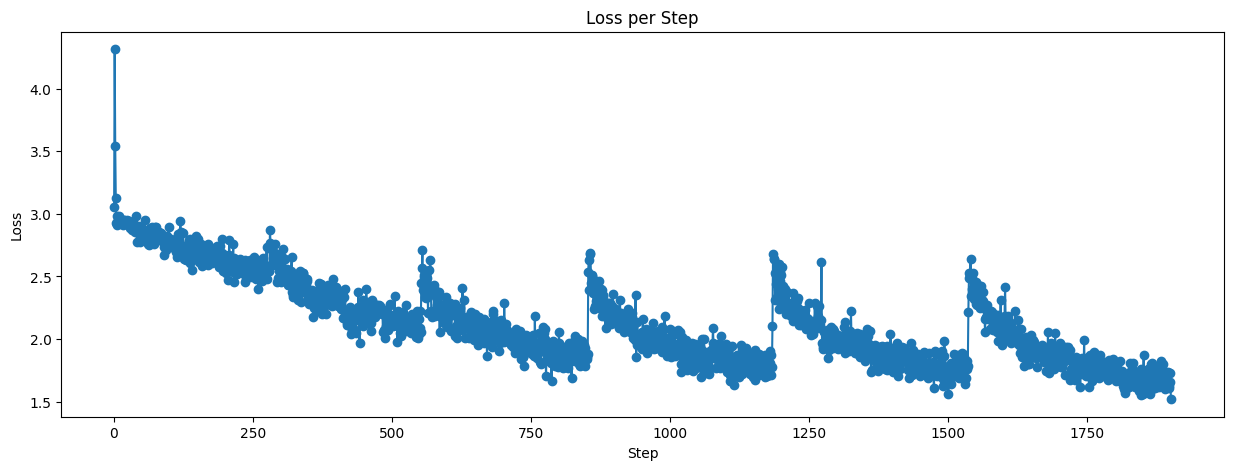

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

game = ConnectFour()
model = ResNet(game, 9, 128, device)

checkpoint = torch.load("weights/" + "ConnectFour_5.pt", map_location=device)

losses = [loss.item() for loss in checkpoint['losses']]

# create a list for the steps, assuming each loss corresponds to one step
steps = list(range(1, len(losses) + 1))

plt.figure(figsize=(15, 5))

# create the line plot
plt.plot(steps, losses, marker='o')

# label the axes
plt.xlabel('Step')
plt.ylabel('Loss')

# title for the plot
plt.title('Loss per Step')

# display the plot
plt.show()

## Manually play against the model

In [12]:
def initialize_game_components(model_path: str) -> Tuple:
    """
    Initializes and returns game, player, args, device, model and Monte Carlo Tree Search (MCTS).

    Returns:
        Tuple: Contains the game, player, args, device, model and MCTS.
    """

    # Initialize a ConnectFour game instance and set the starting player
    game = ConnectFour()
    player = 1  # Player 1 goes first

    # Define the parameters for AlphaZero. These include the exploration constant 'C', 
    # the number of searches to perform, and parameters related to Dirichlet noise.
    args = {
        'C': 2,
        'num_searches': 600,
        'dirichlet_epsilon': 0.,
        'dirichlet_alpha': 0.3
    }

    # Set the device to be used for tensor operations - use a GPU (CUDA) if available, else use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define the neural network model (a ResNet in this case). The model is then loaded with
    # pre-trained weights from the given file and switched to evaluation mode with model.eval()
    model = ResNet(game, 9, 128, device)

    # Load the checkpoint.
    checkpoint = torch.load(model_path, map_location=device)

    # Load the model state.
    model.load_state_dict(checkpoint['model_state_dict'])
    

    model.eval()

    # Initialize the Monte Carlo Tree Search with the ConnectFour game, parameters, and model
    mcts = MCTS(game, args, model)

    return game, player, args, device, model, mcts

def play_game(game: ConnectFour, player: int, mcts: MCTS):
    """
    Plays a game of Connect Four using the provided game state, player information, and Monte Carlo Tree Search (MCTS) instance.

    This function runs a game loop that continues until a terminal state is reached (a player has won or the game is a draw).
    Player 1's moves are input manually, while Player 2's moves are determined using MCTS.

    Args:
        game (ConnectFour): An instance of the ConnectFour game.
        player (int): The current player (1 for the first player, -1 for the second player).
        mcts (MCTS): An instance of Monte Carlo Tree Search used for decision-making by the AI player.

    """


    # Start the game from the initial state
    state = game.get_initial_state()

    # Loop until the game ends
    while True:
        # Print the current state of the game
        print(state)

        # Player 1's turn (human)
        if player == 1:
            # Get the list of valid moves in the current state
            valid_moves = game.get_valid_moves(state)
            print("valid_moves", [i for i in range(game.action_size) if valid_moves[i] == 1])

            # Ask for human input for the next move
            action = int(input(f"{player}:"))

            # Check if the chosen action is valid
            if valid_moves[action] == 0:
                print("action not valid")
                continue

        # Player 2's turn (AI)
        else:
            # Adjust the state to be from Player 2's perspective
            neutral_state = game.change_perspective(state, player)

            # Get the probabilities of each action from Monte Carlo Tree Search
            mcts_probs = mcts.search(neutral_state)

            # Choose the action with the highest probability
            action = np.argmax(mcts_probs)

        # Execute the action and get the new state
        state = game.get_next_state(state, action, player)

        # Get the value of the new state and check if the game has ended
        value, is_terminal = game.get_value_and_terminated(state, action)

        # If the game has ended
        if is_terminal:
            print(state)

            # Announce the result of the game
            if value == 1:
                print(player, "won")
            else:
                print("draw")
            break  # Exit the game loop

        # Switchto the other player for the next turn
        player = game.get_opponent(player)

# Initialize game components: game, player, args, device, model, and MCTS
game, player, args, device, model, mcts = initialize_game_components("weights/ConnectFour_5.pt")

# Start playing the game with the initialized components
play_game(game, player, mcts)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [-1.  0.  0.  1.  1.  0.  0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0

## Tournament of all models playing against each other

In [16]:
def create_game_agents(model_path: str, game_args: Dict, device: str, env) -> Tuple:
    """
    Creates game, loads model, initializes agents.

    Args:
        model_path (str): Path to the pre-trained model.
        game_args (Dict): Game configuration arguments.
        device (str): Device on which to run the model, typically either 'cuda' or 'cpu'.
        env: The game environment.

    Returns:
        Tuple: A tuple containing list of player functions.
    """

    # Create a ConnectFour game instance.
    game = ConnectFour()

    # Initialize a ResNet model instance for the game, with 9 residual blocks and 128 neurons per layer. 
    # The device argument specifies the hardware on which the model will run.
    model = ResNet(game, 9, 128, device)

    # Load the pre-trained model from the provided path, if it exists.
    if model_path is not None:
        print(model_path)
        # Load the checkpoint.
        checkpoint = torch.load("weights/" + model_path, map_location=device)

        # Load the model state.
        model.load_state_dict(checkpoint['model_state_dict'])

    # Switch the model to evaluation mode. This disables operations specific to training such as dropout.
    model.eval()

    # Initialize two instances of the GamePlayingAgent class. Each agent will play the game using 
    # the same pre-trained model and game parameters.
    player1 = GamePlayingAgent(model, game, game_args)
    player2 = GamePlayingAgent(model, game, game_args)

    # Return a list of function references for the two players.
    return [player1.run, player2.run]

In [18]:
# Define game configuration parameters. These will be used by the GamePlayingAgent to guide its actions.
game_args = {
    'C': 2,
    'num_searches': 100,
    'dirichlet_epsilon': 0.1,
    'dirichlet_alpha': 0.3,
    'search': True,
    'temperature': 0,
}

# Choose the device to run the model on. If a CUDA-compatible GPU is available, it will be used. Otherwise, use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the total number of training iterations and games per match
num_iterations = 6
games_per_match = 10

# Initialize matrices
win_matrix = np.zeros((num_iterations + 1, num_iterations + 1))  # Plus 1 for the untrained model
draw_matrix = np.zeros((num_iterations + 1, num_iterations + 1))  # Plus 1 for the untrained model
loss_matrix = np.zeros((num_iterations + 1, num_iterations + 1))  # Plus 1 for the untrained model

# Generate a list of models from the training iterations
model_files = [None] + [f"ConnectFour_{i}.pt" for i in range(num_iterations)]  # Used to load models
# Generate a list of model labels for the heatmap
model_labels = ["Untrained"] + [f"Iteration {i}" for i in range(num_iterations)]  # Used for labeling

# Create an environment for the ConnectFour game using Kaggle's environment utility.
env = kaggle_environments.make("connectx",{"rows": 6, "columns": 7})

# Generate the game agents for each model
agents = [create_game_agents(model, game_args, device, env) for model in model_files]

# Run the tournament
for i in tqdm.tqdm(range(num_iterations + 1), desc="Tournament Progress"):
    for j in range(i+1, num_iterations + 1):  # Only need to play once for each pair
        # Play games_per_match games, half starting with player 1, half with player 2
        for _ in range(games_per_match // 2):
            env.reset()
            env.run([agents[i][0], agents[j][1]])  # i starts
            if env.state[0]['reward'] == 1:  # Player 1 wins
                win_matrix[i, j] += 1
                loss_matrix[j, i] += 1
            elif env.state[0]['reward'] == -1:  # Player 2 wins
                win_matrix[j, i] += 1
                loss_matrix[i, j] += 1
            else:  # Draw
                draw_matrix[i, j] += 1
                draw_matrix[j, i] += 1

            env.reset()
            env.run([agents[j][0], agents[i][1]])  # j starts
            if env.state[0]['reward'] == 1:  # Player 1 wins
                win_matrix[j, i] += 1
                loss_matrix[i, j] += 1
            elif env.state[0]['reward'] == -1:  # Player 2 wins
                win_matrix[i, j] += 1
                loss_matrix[j, i] += 1
            else:  # Draw
                draw_matrix[i, j] += 1
                draw_matrix[j, i] += 1

ConnectFour_0.pt
ConnectFour_1.pt
ConnectFour_2.pt
ConnectFour_3.pt
ConnectFour_4.pt
ConnectFour_5.pt


Tournament Progress: 100%|██████████| 7/7 [30:12<00:00, 258.95s/it]


## Plot the tournament results

In the tournament the players played against each other 10 times (5 times Player-1 makes the first move and 5 times Player-2). The players are the untrained (randomly initialized) model and all trained model iterations.

The matrix displays the results of the tournament from the perspective of player 1. The cell at the bottom left (Player 1: Iteration 5; Player 2: Untrained) states that:
- Player 1 scored 30 points against Player 2 (bold black value)
- Player 1 won 10 times (green value)
- Player 1 played draw 0 times (black value)
- Player 1 lost 0 times (red value)

(Point distribution: Win = 3; Draw = 1, Loss = 0)

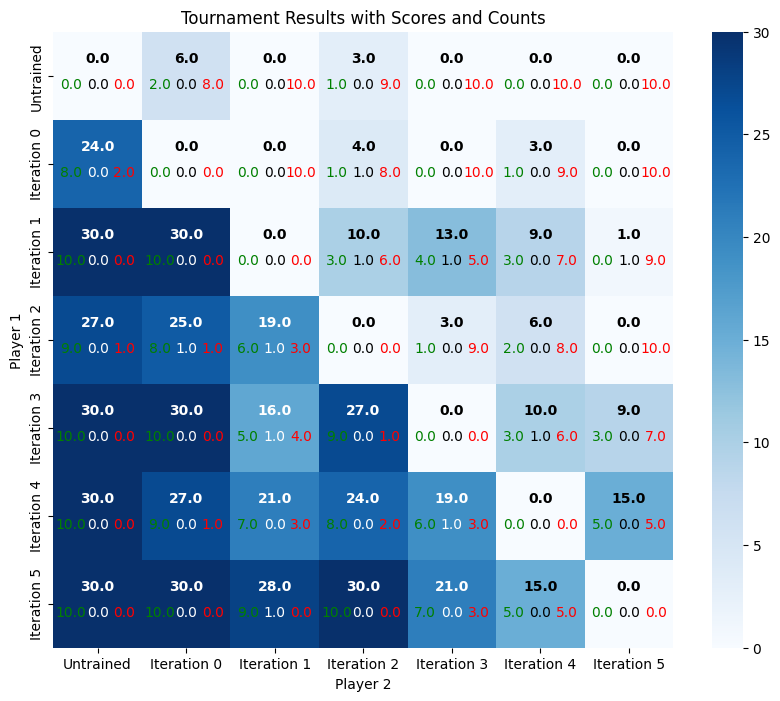

In [19]:
# Compute the score matrix
score_matrix = 3 * win_matrix + draw_matrix  # Win: +3, Draw: +1, Loss: 0

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Create the heatmap using seaborn
sns.heatmap(score_matrix, xticklabels=model_labels, yticklabels=model_labels, cmap="Blues", ax=ax)

# Add labels and title
ax.set_xlabel("Player 2")
ax.set_ylabel("Player 1")
plt.title("Tournament Results with Scores and Counts")

# Loop over the data to add text annotations for scores, win/draw/loss counts in different colors
for i in range(score_matrix.shape[0]):
    for j in range(score_matrix.shape[1]):
        text_color = "white" if score_matrix[i, j] > 0.5 * score_matrix.max() else "black"
        score_text = ax.text(j+0.5, i+0.3, str(score_matrix[i, j]), 
                             ha="center", va="center", color=text_color, fontweight='bold')

        # Position of the text is manually set and may require adjustments based on your specific case
        win_text = ax.text(j+0.2, i+0.6, str(win_matrix[i, j]), 
                           ha="center", va="center", color="green")

        draw_text = ax.text(j+0.5, i+0.6, str(draw_matrix[i, j]), 
                            ha="center", va="center", color=text_color)

        loss_text = ax.text(j+0.8, i+0.6, str(loss_matrix[i, j]), 
                            ha="center", va="center", color="red")

plt.show()

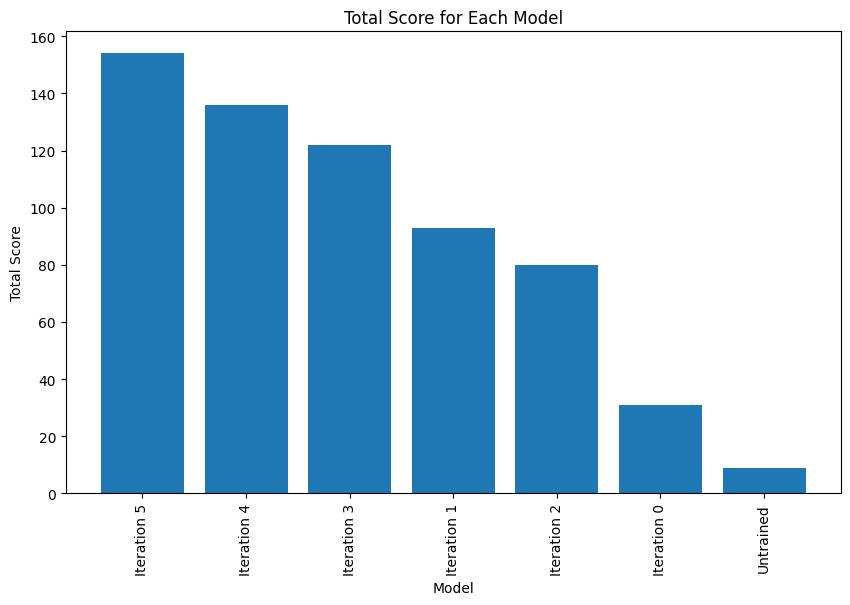

In [38]:
# Compute the total score for each model by summing across rows
total_scores = np.sum(score_matrix, axis=1)

# Create a sorted list of (score, label) pairs, sorted by score in descending order
sorted_scores = sorted(zip(total_scores, model_labels), reverse=True)

# Unzip the sorted list into two separate lists
sorted_total_scores, sorted_labels = zip(*sorted_scores)

# Generate the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_labels, sorted_total_scores)
plt.xlabel('Model')
plt.ylabel('Total Score')
plt.title('Total Score for Each Model')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()